In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

# PyTorch imports
import torch

# This has neural network layer primitives that you can use to build things quickly
import torch.nn as nn

# This has things like activation functions and other useful nonlinearities
from torch.nn import functional as F

# This has various gradient descent algorithms
import torch.optim

# In order to take derivatives, we have to wrap things as a Variable or a Parameter.
# Variables are things like inputs to the model
# Parameters are things like weights
# If you make a child class of nn.Module, it automatically keeps tracks of all parameters declared during 
# __init__ for you - really handy!
from torch.autograd import Variable
from torch.nn import Parameter

from IPython import display
import time

Populating the interactive namespace from numpy and matplotlib


## Generative Adversarial Networks

Generative adversarial networks (GANs) are a method to learn to produce samples from high-dimensional distributions based only on a set of samples from that distribution. The basic idea is that you have two networks which are competing with eachother on a shared game. One network (the Generator) must create samples from the target distribution, while the other network (the Discriminator) must correctly predict whether a given sample came from the Generator or from the actual data set.

For this game, the Nash equilibrium is for the Generator to produce samples exactly according to the probability density of the data distribution, and for the Discriminator to return the probability density of a given input sample. So a trained GAN in principle gives you both a way to sample from a distribution as well as a way to evaluate the local probability density around a sample.

In practice, the Generator and Discriminator may not converge to the Nash equilibrium, but will often oscillate around it, overspecialize to sub-regions of the distribution ('mode collapse'), etc. As such, there are a large family of algorithms designed to improve the convergence properties of the basic setup. 

In this example, we'll just implement a basic GAN to reproduce some 2d distributions (so that the quality of the reconstruction can be easily checked). 

In [2]:
# Some utility functions

def toFloatVar(x):
    return Variable(torch.FloatTensor(x), requires_grad=False)

def toLongVar(x):
    return Variable(torch.LongTensor(x), requires_grad=False)

## Generator network

First we'll specify the Generator. This network needs to produce a distribution of outcomes, not just an input-output relationship or single output, so we need to provide it a source of noise that it will transform into the target distribution. In essence, the Generator implements a transform from one probability distribution $p(z)$ to a target distribution (in a different set of variables) $q(x)$ - one sample at a time.

So basically the procedure is, we sample a random $z$ from $p(z)$ (which will just be a high-dimensional Gaussian), then apply the network to get $x = G(z)$.

In [36]:
class Generator(nn.Module):
    def __init__(self, noiseDimension = 16, hiddenDimension = 64, targetDimension = 2):
        super(Generator,self).__init__()
        
        self.layer1 = nn.Linear(noiseDimension, hiddenDimension)
        self.layer2 = nn.Linear(hiddenDimension, hiddenDimension)
        self.layer3 = nn.Linear(hiddenDimension, hiddenDimension)
        self.layer4 = nn.Linear(hiddenDimension, targetDimension)
        
        self.noiseDimension = noiseDimension
        # Each network will have its own optimizer, so we can train them at cross purposes to each-other
        self.optimizer = torch.optim.Adam(self.parameters(), lr = 1e-3)
    
    # For forward, we want to get samples based on specific values of the noise input
    def forward(self, x):
        z = F.relu(self.layer1(x))
        z = F.relu(self.layer2(z))
        z = F.relu(self.layer3(z))
        z = self.layer4(z)
        
        return z
    
    # For convenience, lets also make a function that generates a batch of random samples
    def sample(self, N=100):
        z = toFloatVar(np.random.randn(N, self.noiseDimension))
        return self.forward(z)

## Discriminator Network

The Discriminator network takes a sample either from the true dataset or from fakes made by the Generator, and should return a probability that the sample is real or fake. 

In [37]:
class Discriminator(nn.Module):
    def __init__(self, hiddenDimension = 64, targetDimension = 2):
        super(Discriminator,self).__init__()
        
        self.layer1 = nn.Linear(targetDimension, hiddenDimension)
        self.layer2 = nn.Linear(hiddenDimension, hiddenDimension)
        self.layer3 = nn.Linear(hiddenDimension, hiddenDimension)
        self.layer4 = nn.Linear(hiddenDimension, 1)
        
        # Each network will have its own optimizer, so we can train them at cross purposes to each-other
        self.optimizer = torch.optim.Adam(self.parameters(), lr = 1e-3)
    
    def forward(self, x):
        z = F.relu(self.layer1(x))
        z = F.relu(self.layer2(z))
        z = F.relu(self.layer3(z))
        
        # Clamp for numerical stability
        z = torch.clamp( F.sigmoid(self.layer4(z)), 1e-6, 1-1e-6)
        
        return z

## Training

The training procedure involves two steps: training the Discriminator and training the Generator. We'll do these separately for clarity, despite that introducing a bit of redundancy.

Training the discriminator:
- Form a batch which contains 50% samples from true distribution and 50% samples from the generator
- If $D()$ is the output of the discriminator and $x$ the true data, minimize the logistic loss: $L = -\log(D(x)) - \log(1-D(G(z)))$
- Update the discriminator weights only

Training the generator:
- Form a batch containing 100% samples from the generator
- Apply the discriminator to get $D(G(z))$
- Update the generator to maximize the discriminator's loss: $L = \log(1-D(G(z)))$.

In [38]:
def trainDiscriminator(data, generator, discriminator):
    fakes = generator.sample(N=data.shape[0])
    
    # Zero the discriminator gradient
    discriminator.zero_grad()
    
    # Get the fake batch and true batch
    p_fakes = discriminator.forward(fakes)
    p_true = discriminator.forward(data)
    
    # Compute the loss
    loss = torch.mean(-torch.log(p_true)) + torch.mean(-torch.log(1-p_fakes))
    
    # Update the discriminator weights only
    loss.backward()
    discriminator.optimizer.step()
    
    # Get the loss to follow training progress
    return loss.data.numpy().copy()

# Training the generator doesn't require access to the dataset
# Careful though - training to completion on a fixed discriminator leads to mode collapse
# We have to train them together dynamically

def trainGenerator(generator, discriminator):
    # Zero generator gradient
    generator.zero_grad()
    
    fakes = generator.sample(N=250)
    p_fakes = discriminator.forward(fakes)
    
    # Get the generator loss
    loss = torch.mean(torch.log(1-p_fakes))
    
    # Update generator weights
    loss.backward()
    generator.optimizer.step()
    
    # Track generator loss for training
    return loss.data.numpy().copy()

## Data distribution

We'll learn a simple bimodal distribution to test the GAN

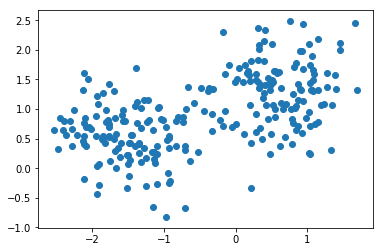

In [39]:
def generateData(N):
    # Generate which mode we're in
    x = np.random.randint(2,size=(N,1))
    
    # Generate Gaussian fluctuations around the mode
    z = np.random.randn(N,2)*0.5
    
    # Centers of the two modes
    centers = np.array([[-1.5,0.5], [0.6, 1.3]])
    
    return centers[x[:,0]] + z

data = generateData(250)

plt.scatter(data[:,0],data[:,1])
plt.show()

## Training the GAN

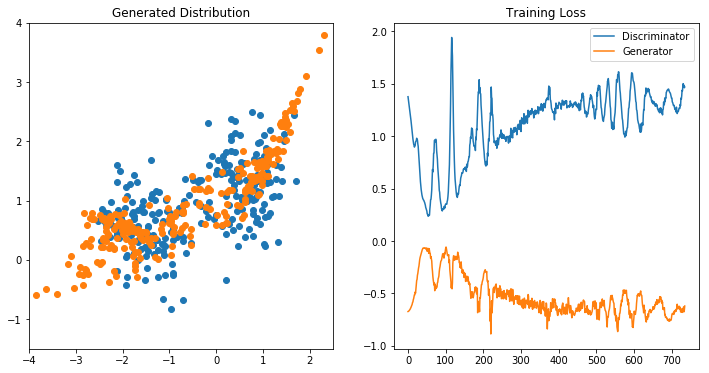

KeyboardInterrupt: 

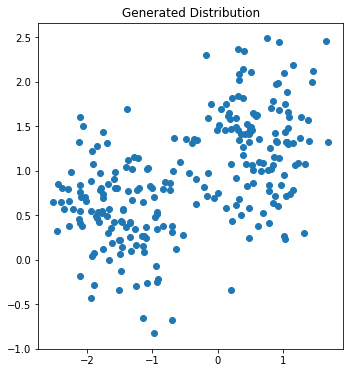

In [40]:
generator = Generator()
discriminator = Discriminator()

gen_loss = []
disc_loss = []

for epoch in range(1000):
    # It's often better for the discriminator to be slightly better than the generator for stability
    # So we'll use two steps here
    dl = trainDiscriminator(toFloatVar(data), generator, discriminator)
    dl = trainDiscriminator(toFloatVar(data), generator, discriminator)
    
    gl = trainGenerator(generator, discriminator)
    
    gen_loss.append(gl)
    disc_loss.append(dl)
    
    if epoch%5 == 0:
        samples = generator.sample(N=250)

        plt.clf()
        plt.subplot(1,2,1)
        plt.title("Generated Distribution")
        plt.scatter(data[:,0],data[:,1])
        plt.scatter(samples[:,0],samples[:,1])
        plt.xlim(-4,2.5)
        plt.ylim(-1.5,4)

        plt.subplot(1,2,2)
        plt.title("Training Loss")
        plt.plot(disc_loss,label="Discriminator")
        plt.plot(gen_loss,label="Generator")
        plt.legend()

        plt.gcf().set_size_inches((12,6))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.01)